In [1]:
%cd ..
%pwd

/home/guilherme/scantensus-sdy


/home/guilherme/.ai-env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/guilherme/scantensus-sdy'

In [2]:
from pathlib import Path

from src.pressure_damping.label_processer import FirebaseCurveFetcher
from src.utils.cluster_source import ClusterSource

from src.utils.matt_heatmap import UnityMakeHeatmaps
from src.pressure_damping.pretransformations import PretransformationsModule
from src.pressure_damping.curve_dataset import CurveDataset

import numpy as np
import torch
import torchvision

from matplotlib import cm
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive

import PIL
import PIL.Image

IMAGE_SHAPE = (170, 422)

dataset = CurveDataset(
    projects=['imp-coro-flow-inv'],
    output_shape=IMAGE_SHAPE,
    firebase_certificate=Path('.firebase.json')
)

2024-01-14 11:48:16.573 | INFO     | src.pressure_damping.curve_dataset:__init__:74 - Loaded 1 results containing 164 curves.


In [3]:
image, raw_labels, T = dataset[0]

/home/guilherme/scantensus-sdy/src/pressure_damping/curve_dataset.py:152: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:1508.)
  img_bytes = torch.frombuffer(r.content, dtype=torch.uint8)
2024-01-12 19:33:07.719 | DEBUG    | src.pressure_damping.curve_dataset:read_image_into_t:155 - https://storage.googleapis.com/scantensus/fiducial/imp-coro-flow-inv~clusters~Patient_5~Screen_Shot_2019-08-21_at_18.43.55.png: Successfully loaded


/home/guilherme/scantensus-sdy/src/pressure_damping/curve_dataset.py:153: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:1508.)
  img_bytes = torch.frombuffer(r.content, dtype=torch.uint8)
2024-01-14 11:48:16.586 | DEBUG    | src.pressure_damping.curve_dataset:read_image_into_t:156 - https://storage.googleapis.com/scantensus/fiducial/imp-coro-flow-inv~clusters~Patient_5~Screen_Shot_2019-08-21_at_18.43.55.png: Successfully loaded
/home/guilherme/scantensus-sdy/src/utils/matt_heatmap.py:553: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internall

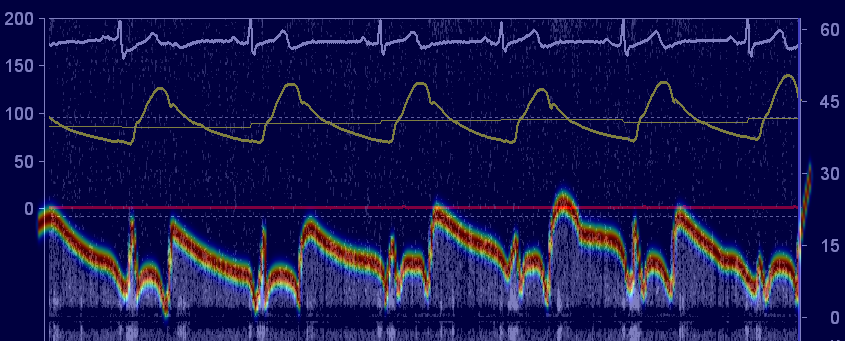

In [3]:
def plot_image_with_heatmap(index: int):
    image, raw_labels, T = dataset[index]

    H = image.shape[1]
    W = image.shape[2]

    heatmap_gen = UnityMakeHeatmaps(
        keypoint_names=['curve-flow'],
        image_crop_size=(H, W),
        image_out_size=(H, W)
    )

    heatmaps, weights = heatmap_gen(
        label_data=[raw_labels],
        label_height_shift=[0],
        label_width_shift=[0],
        transform_matrix=[torch.eye(3)]
    )

    # apply the 3x3 transform matrix T to the image
    

    # rendering stuff

    heatmap = heatmaps[0].squeeze()
    jet_map = cm.get_cmap('jet')

    heatmap_jetted = PIL.Image.fromarray((jet_map(heatmap.numpy()) * 255).astype(np.uint8))

    SHOW_H = H // 1
    SHOW_W = W // 1

    resized_heatmap = torchvision.transforms.Resize((SHOW_H, SHOW_W))(heatmap_jetted)
    original_image = torchvision.transforms.Resize((SHOW_H, SHOW_W))(torchvision.transforms.ToPILImage()(image))

    resized_heatmap = resized_heatmap.convert('RGBA')
    original_image = original_image.convert('RGBA')

    blended = PIL.Image.blend(original_image, resized_heatmap, alpha=0.5)

    return blended

plot_image_with_heatmap(0)

In [4]:
def new_plot_image_with_heatmap(index: int):
    image, raw_labels, T = dataset[index]

    pretransform = PretransformationsModule(
        keypoint_names=['curve-flow'],
        image_crop_size=IMAGE_SHAPE,
        image_out_size=IMAGE_SHAPE
    )

    images, heatmaps, weights = pretransform.forward(
        label_data=[raw_labels],
        images=image.unsqueeze(0),
        dataset_transform_matrices=[T]
    )

    heatmap = heatmaps[0].squeeze()
    jet_map = cm.get_cmap('jet')

    heatmap_jetted = PIL.Image.fromarray((jet_map(heatmap.numpy()) * 255).astype(np.uint8)).convert('RGBA')
    heatmap_jetted = heatmap_jetted.resize((IMAGE_SHAPE[1], IMAGE_SHAPE[0]))

    image = torchvision.transforms.ToPILImage()(images.to(torch.uint8).squeeze()).convert('RGBA')

    return image, heatmap_jetted

image, heatmap = new_plot_image_with_heatmap(0)

2024-01-14 11:56:09.528 | DEBUG    | src.pressure_damping.curve_dataset:read_image_into_t:156 - https://storage.googleapis.com/scantensus/fiducial/imp-coro-flow-inv~clusters~Patient_5~Screen_Shot_2019-08-21_at_18.43.55.png: Successfully loaded
/tmp/ipykernel_2764768/3428228241.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet_map = cm.get_cmap('jet')


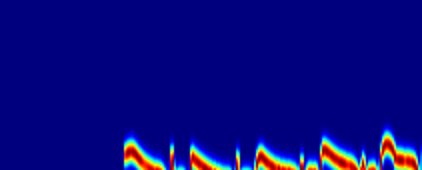

In [5]:
#PIL.Image.blend(image, heatmap, alpha=0.5)
heatmap